<a href="https://colab.research.google.com/github/sarah-mokhtar/RL-Project-2048/blob/main/2048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3[extra] gymnasium numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.0 MB/s eta 0:00:00


In [2]:
!pip install gymnasium stable-baselines3 sb3-contrib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.4 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import gymnasium as gym
from gymnasium import spaces

import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.monitor import Monitor

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
class Game2048MaskedEnv(gym.Env):
    """
    2048 environment with:
      - action masking (get_action_mask)
      - log-based rewards for merges
      - extra shaping for empty squares and max tile
      - CNN-friendly observations (4x4 float32 in [0,1])
    """

    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile
        self.render_mode = render_mode

        # Actions: 0=up, 1=down, 2=left, 3=right
        self.action_space = spaces.Discrete(4)

        # Obs: 4x4 grid, values normalized log2(tile)/max_exp
        self.max_exp = 16  # allow up to 2^16
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.board_size, self.board_size),
            dtype=np.float32,
        )

        self.rng = np.random.default_rng()
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0
        self.reset()

    # ---------- Gym API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0

        self._add_random_tile()
        self._add_random_tile()

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": int(self.board.max())}
        return obs, info

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"
        old_board = self.board.copy()
        empties_before = int((old_board == 0).sum())
        max_before = int(old_board.max())

        # apply move (no random tile here)
        new_board, merge_score = self._move_board(old_board, action)
        moved = not np.array_equal(new_board, old_board)

        reward = 0.0

        if moved:
          self.board = new_board
          self.score += merge_score

          self._add_random_tile()

          empties_after = int((self.board == 0).sum())
          max_after = int(self.board.max())

          # ---------------------------------------------------------
          # 1) Merge reward: STRONGEST signal
          # ---------------------------------------------------------
          if merge_score > 0:
              reward_merge = 1.2 * float(np.log2(merge_score + 1.0))
          else:
              reward_merge = 0.0

          # ---------------------------------------------------------
          # 2) Empty tile reward: small shaping
          # ---------------------------------------------------------
          reward_empty = 0.01 * (empties_after - empties_before)

          # ---------------------------------------------------------
          # 3) Max tile progress: EXPLICIT milestone bonuses
          # ---------------------------------------------------------
          reward_max = 0.0
          if max_after > max_before and max_after > 0:
              reward_max += 0.8 * (np.log2(max_after) - np.log2(max_before if max_before > 0 else 1))

              # Bonus milestones
              if max_after >= 512:
                  reward_max += 1.0
              if max_after >= 1024:
                  reward_max += 3.0
              if max_after >= 2048:
                  reward_max += 6.0
              if max_after >= 4096:
                  reward_max += 12.0

          # ---------------------------------------------------------
          # 4) Smoothness (small negative reward)
          # ---------------------------------------------------------
          smoothness = 0
          for r in range(4):
              for c in range(3):
                  smoothness += abs(self.board[r, c] - self.board[r, c + 1])
          for c in range(4):
              for r in range(3):
                  smoothness += abs(self.board[r, c] - self.board[r + 1, c])
          reward_smooth = -1e-4 * smoothness

          reward = reward_merge + reward_empty + reward_max + reward_smooth

        else:
          reward = -0.1  # small penalty for no-op



        terminated = (not self._can_move()) or (self.board.max() >= self.target_tile)
        truncated = False

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": int(self.board.max())}
        return obs, reward, terminated, truncated, info

    # ---------- Observation & Rendering ----------

    def _get_obs(self):
        """
        Convert board of tile values (0,2,4,...) to 4x4 float32 in [0,1]:
        obs[r,c] = log2(tile) / max_exp, with tile 0 -> 0
        """
        obs = np.zeros_like(self.board, dtype=np.float32)
        nonzero = self.board > 0
        obs[nonzero] = np.log2(self.board[nonzero]).astype(np.float32) / self.max_exp
        return obs

    def render(self):
        print("\nScore:", self.score)
        print("-" * 25)
        for row in self.board:
            print(
                "|"
                + "|".join(f"{num:^5}" if num != 0 else "     " for num in row)
                + "|"
            )
            print("-" * 25)

    # ---------- Core movement logic ----------

    def _compress_and_merge_line(self, line):
        """
        Given a 1D array of tiles (length 4),
        slide left and merge equal tiles once per move.
        Returns (new_line, merge_sum).
        """
        non_zero = [x for x in line if x != 0]
        merged = []
        merge_sum = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
                val = non_zero[i] * 2
                merged.append(val)
                merge_sum += val
                i += 2
            else:
                merged.append(non_zero[i])
                i += 1
        merged += [0] * (len(line) - len(merged))
        return np.array(merged, dtype=np.int32), merge_sum

    def _move_board(self, board, action):
        """
        Apply the move to a given board (without adding a random tile).
        Returns (new_board, merge_score).
        """
        new_board = np.zeros_like(board)
        total_merge = 0

        if action == 2:  # left
            for r in range(self.board_size):
                new_row, gained = self._compress_and_merge_line(board[r, :])
                new_board[r, :] = new_row
                total_merge += gained

        elif action == 3:  # right
            for r in range(self.board_size):
                reversed_row = board[r, ::-1]
                new_row, gained = self._compress_and_merge_line(reversed_row)
                new_board[r, :] = new_row[::-1]
                total_merge += gained

        elif action == 0:  # up
            for c in range(self.board_size):
                col = board[:, c]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col
                total_merge += gained

        elif action == 1:  # down
            for c in range(self.board_size):
                col = board[:, c][::-1]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col[::-1]
                total_merge += gained

        else:
            raise ValueError(f"Invalid action {action}")

        return new_board, total_merge

    def _add_random_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        r, c = empty[self.rng.integers(len(empty))]
        # 90% chance of 2, 10% chance of 4
        self.board[r, c] = 4 if self.rng.random() < 0.1 else 2

    def _can_move(self):
        # any empty cell?
        if (self.board == 0).any():
            return True
        # any merges horizontally?
        for r in range(self.board_size):
            for c in range(self.board_size - 1):
                if self.board[r, c] == self.board[r, c + 1]:
                    return True
        # any merges vertically?
        for c in range(self.board_size):
            for r in range(self.board_size - 1):
                if self.board[r, c] == self.board[r + 1, c]:
                    return True
        return False

    # ---------- Action masking ----------

    def get_action_mask(self):
        """
        Returns a boolean array of shape (4,):
        True  = action changes the board
        False = action is a no-op
        """
        mask = np.zeros(self.action_space.n, dtype=bool)
        for a in range(self.action_space.n):
            new_board, _ = self._move_board(self.board, a)
            mask[a] = not np.array_equal(new_board, self.board)

        # If no action changes the board, it should be terminal.
        # To keep MaskablePPO happy, allow all actions in that case.
        if not mask.any():
            mask[:] = True

        return mask


In [4]:
class Game2048MaskedEnvSimple(gym.Env):
    """
    2048 environment with:
      - action masking (get_action_mask)
      - log-based rewards for merges
      - extra shaping for empty squares and max tile
      - CNN-friendly observations (4x4 float32 in [0,1])
    """

    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile
        self.render_mode = render_mode
        self.max_tile_reached = 0

        # Actions: 0=up, 1=down, 2=left, 3=right
        self.action_space = spaces.Discrete(4)

        # Obs: 4x4 grid, values normalized log2(tile)/max_exp
        self.max_exp = 16  # allow up to 2^16
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.board_size, self.board_size),
            dtype=np.float32,
        )

        self.rng = np.random.default_rng()
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0
        self.reset()

    # ---------- Gym API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0

        self._add_random_tile()
        self._add_random_tile()

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": int(self.board.max())}
        return obs, info

    def step(self, action):
      assert self.action_space.contains(action), "Invalid action"

      old_board = self.board.copy()
      score_before = self.score
      max_before = int(self.board.max())

      # Apply move (no random tile yet)
      new_board, merge_score = self._move_board(old_board, action)
      moved = not np.array_equal(new_board, old_board)

      if moved:
          # update board + score
          self.board = new_board
          self.score += merge_score

          # add new tile
          self._add_random_tile()

          max_after = int(self.board.max())

          # --- base reward: scaled merge score ---
          reward = merge_score / 16.0   # you can later try /8.0 if too weak

          # --- milestone rewards (only when you pass a new threshold this episode) ---
          if max_after > self.max_tile_reached:
              # update tracker
              self.max_tile_reached = max_after

              # milestone bonuses
              if max_after >= 128:
                  reward += 1.0
              if max_after >= 256:
                  reward += 2.0
              if max_after >= 512:
                  reward += 5.0
              if max_after >= 1024:
                  reward += 15.0
              if max_after >= 2048:
                  reward += 30.0

      else:
          # invalid / no-op move
          reward = -0.1

      terminated = (not self._can_move()) or (self.board.max() >= self.target_tile)
      truncated = False

      obs = self._get_obs()
      info = {
          "score": self.score,
          "max_tile": int(self.board.max())
      }
      return obs, reward, terminated, truncated, info



    # ---------- Observation & Rendering ----------

    def _get_obs(self):
        """
        Convert board of tile values (0,2,4,...) to 4x4 float32 in [0,1]:
        obs[r,c] = log2(tile) / max_exp, with tile 0 -> 0
        """
        obs = np.zeros_like(self.board, dtype=np.float32)
        nonzero = self.board > 0
        obs[nonzero] = np.log2(self.board[nonzero]).astype(np.float32) / self.max_exp
        return obs

    def render(self):
        print("\nScore:", self.score)
        print("-" * 25)
        for row in self.board:
            print(
                "|"
                + "|".join(f"{num:^5}" if num != 0 else "     " for num in row)
                + "|"
            )
            print("-" * 25)

    # ---------- Core movement logic ----------

    def _compress_and_merge_line(self, line):
        """
        Given a 1D array of tiles (length 4),
        slide left and merge equal tiles once per move.
        Returns (new_line, merge_sum).
        """
        non_zero = [x for x in line if x != 0]
        merged = []
        merge_sum = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
                val = non_zero[i] * 2
                merged.append(val)
                merge_sum += val
                i += 2
            else:
                merged.append(non_zero[i])
                i += 1
        merged += [0] * (len(line) - len(merged))
        return np.array(merged, dtype=np.int32), merge_sum

    def _move_board(self, board, action):
        """
        Apply the move to a given board (without adding a random tile).
        Returns (new_board, merge_score).
        """
        new_board = np.zeros_like(board)
        total_merge = 0

        if action == 2:  # left
            for r in range(self.board_size):
                new_row, gained = self._compress_and_merge_line(board[r, :])
                new_board[r, :] = new_row
                total_merge += gained

        elif action == 3:  # right
            for r in range(self.board_size):
                reversed_row = board[r, ::-1]
                new_row, gained = self._compress_and_merge_line(reversed_row)
                new_board[r, :] = new_row[::-1]
                total_merge += gained

        elif action == 0:  # up
            for c in range(self.board_size):
                col = board[:, c]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col
                total_merge += gained

        elif action == 1:  # down
            for c in range(self.board_size):
                col = board[:, c][::-1]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col[::-1]
                total_merge += gained

        else:
            raise ValueError(f"Invalid action {action}")

        return new_board, total_merge

    def _add_random_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        r, c = empty[self.rng.integers(len(empty))]
        # 90% chance of 2, 10% chance of 4
        self.board[r, c] = 4 if self.rng.random() < 0.1 else 2

    def _can_move(self):
        # any empty cell?
        if (self.board == 0).any():
            return True
        # any merges horizontally?
        for r in range(self.board_size):
            for c in range(self.board_size - 1):
                if self.board[r, c] == self.board[r, c + 1]:
                    return True
        # any merges vertically?
        for c in range(self.board_size):
            for r in range(self.board_size - 1):
                if self.board[r, c] == self.board[r + 1, c]:
                    return True
        return False

    # ---------- Action masking ----------

    def get_action_mask(self):
        """
        Returns a boolean array of shape (4,):
        True  = action changes the board
        False = action is a no-op
        """
        mask = np.zeros(self.action_space.n, dtype=bool)
        for a in range(self.action_space.n):
            new_board, _ = self._move_board(self.board, a)
            mask[a] = not np.array_equal(new_board, self.board)

        # If no action changes the board, it should be terminal.
        # To keep MaskablePPO happy, allow all actions in that case.
        if not mask.any():
            mask[:] = True

        return mask


In [40]:
class Game2048MaskedEnvSimpleBiggerReward(gym.Env):
    """
    2048 environment with:
      - action masking (get_action_mask)
      - log-based rewards for merges
      - extra shaping for empty squares and max tile
      - CNN-friendly observations (4x4 float32 in [0,1])
    """

    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile
        self.render_mode = render_mode
        self.step_count = 0
        self.max_tile_reached = 0

        # Actions: 0=up, 1=down, 2=left, 3=right
        self.action_space = spaces.Discrete(4)

        # Obs: 4x4 grid, values normalized log2(tile)/max_exp
        self.max_exp = 16  # allow up to 2^16
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.board_size, self.board_size),
            dtype=np.float32,
        )

        self.rng = np.random.default_rng()
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0
        self.reset()

    # ---------- Gym API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0
        self.step_count = 0        # reset here
        self.max_tile_reached = 0  # if you use milestone rewards
        self._add_random_tile()
        self._add_random_tile()

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": int(self.board.max())}
        return obs, info

    def step(self, action):
      assert self.action_space.contains(action), "Invalid action"

      old_board = self.board.copy()
      score_before = self.score
      max_before = int(self.board.max())
      empties_before = int((old_board == 0).sum())
      # Apply move (no random tile yet)
      new_board, merge_score = self._move_board(old_board, action)
      moved = not np.array_equal(new_board, old_board)

      if moved:
          # update board + score
          self.board = new_board
          self.score += merge_score

          # add new tile
          self._add_random_tile()
          empties_after = int((self.board == 0).sum())
          max_after = int(self.board.max())

          # --- base reward: scaled merge score ---
          reward = merge_score / 16.0   # you can later try /8.0 if too weak

          # --- milestone rewards (only when you pass a new threshold this episode) ---
          if max_after > self.max_tile_reached:
              # update tracker
              self.max_tile_reached = max_after

              # milestone bonuses
              if max_after >= 128:
                  reward += 1.0
              if max_after >= 256:
                  reward += 2.0
              if max_after >= 512:
                  reward += 5.0
              if max_after >= 1024:
                  reward += 30.0
              if max_after >= 2048:
                  reward += 60.0
          STEP_THRESHOLD = 25
          TILE_THRESHOLD = 128

          if self.step_count <= STEP_THRESHOLD and max_after <= TILE_THRESHOLD:
              delta_empty = empties_after - empties_before
              # small but noticeable bonus
              reward += 0.05 * delta_empty

      else:
          # invalid / no-op move
          reward = -0.1

      terminated = (not self._can_move()) or (self.board.max() >= self.target_tile)
      truncated = False

      obs = self._get_obs()
      info = {
          "score": self.score,
          "max_tile": int(self.board.max())
      }
      return obs, reward, terminated, truncated, info



    # ---------- Observation & Rendering ----------

    def _get_obs(self):
        """
        Convert board of tile values (0,2,4,...) to 4x4 float32 in [0,1]:
        obs[r,c] = log2(tile) / max_exp, with tile 0 -> 0
        """
        obs = np.zeros_like(self.board, dtype=np.float32)
        nonzero = self.board > 0
        obs[nonzero] = np.log2(self.board[nonzero]).astype(np.float32) / self.max_exp
        return obs

    def render(self):
        print("\nScore:", self.score)
        print("-" * 25)
        for row in self.board:
            print(
                "|"
                + "|".join(f"{num:^5}" if num != 0 else "     " for num in row)
                + "|"
            )
            print("-" * 25)

    # ---------- Core movement logic ----------

    def _compress_and_merge_line(self, line):
        """
        Given a 1D array of tiles (length 4),
        slide left and merge equal tiles once per move.
        Returns (new_line, merge_sum).
        """
        non_zero = [x for x in line if x != 0]
        merged = []
        merge_sum = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
                val = non_zero[i] * 2
                merged.append(val)
                merge_sum += val
                i += 2
            else:
                merged.append(non_zero[i])
                i += 1
        merged += [0] * (len(line) - len(merged))
        return np.array(merged, dtype=np.int32), merge_sum

    def _move_board(self, board, action):
        """
        Apply the move to a given board (without adding a random tile).
        Returns (new_board, merge_score).
        """
        new_board = np.zeros_like(board)
        total_merge = 0

        if action == 2:  # left
            for r in range(self.board_size):
                new_row, gained = self._compress_and_merge_line(board[r, :])
                new_board[r, :] = new_row
                total_merge += gained

        elif action == 3:  # right
            for r in range(self.board_size):
                reversed_row = board[r, ::-1]
                new_row, gained = self._compress_and_merge_line(reversed_row)
                new_board[r, :] = new_row[::-1]
                total_merge += gained

        elif action == 0:  # up
            for c in range(self.board_size):
                col = board[:, c]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col
                total_merge += gained

        elif action == 1:  # down
            for c in range(self.board_size):
                col = board[:, c][::-1]
                new_col, gained = self._compress_and_merge_line(col)
                new_board[:, c] = new_col[::-1]
                total_merge += gained

        else:
            raise ValueError(f"Invalid action {action}")

        return new_board, total_merge

    def _add_random_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        r, c = empty[self.rng.integers(len(empty))]
        # 90% chance of 2, 10% chance of 4
        self.board[r, c] = 4 if self.rng.random() < 0.1 else 2

    def _can_move(self):
        # any empty cell?
        if (self.board == 0).any():
            return True
        # any merges horizontally?
        for r in range(self.board_size):
            for c in range(self.board_size - 1):
                if self.board[r, c] == self.board[r, c + 1]:
                    return True
        # any merges vertically?
        for c in range(self.board_size):
            for r in range(self.board_size - 1):
                if self.board[r, c] == self.board[r + 1, c]:
                    return True
        return False

    # ---------- Action masking ----------

    def get_action_mask(self):
        """
        Returns a boolean array of shape (4,):
        True  = action changes the board
        False = action is a no-op
        """
        mask = np.zeros(self.action_space.n, dtype=bool)
        for a in range(self.action_space.n):
            new_board, _ = self._move_board(self.board, a)
            mask[a] = not np.array_equal(new_board, self.board)

        # If no action changes the board, it should be terminal.
        # To keep MaskablePPO happy, allow all actions in that case.
        if not mask.any():
            mask[:] = True

        return mask

In [7]:
class SmallBoardCNN(BaseFeaturesExtractor):
    """
    Custom CNN for 4x4 2048 board.

    Input obs: (batch, 4, 4) in [0,1].
    Internally: (batch, 1, 4, 4) -> Conv -> ReLU -> Flatten -> Linear.
    """

    def __init__(self, observation_space, features_dim: int = 128):
        super().__init__(observation_space, features_dim)

        self.board_size = observation_space.shape[0]  # 4 expected

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1),  # (1,4,4) -> (32,3,3)
            nn.ReLU(),
            nn.Flatten()
        )

        with th.no_grad():
            dummy = th.zeros(1, 1, self.board_size, self.board_size)
            n_flat = self.cnn(dummy).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flat, features_dim),
            nn.ReLU()
        )

    def forward(self, obs: th.Tensor) -> th.Tensor:
        # obs: (batch, 4, 4) -> (batch, 1, 4, 4)
        x = obs.unsqueeze(1)
        x = self.cnn(x)
        x = self.linear(x)
        return x


In [73]:
def mask_fn(env: Game2048MaskedEnv):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnv()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 1e-4,   # ⬅ bump this up
    n_steps       = 4096,
    batch_size    = 512,    # ⬅ a bit larger batch
    n_epochs      = 20,
    gamma         = 0.99,   # ⬅ slightly shorter horizon
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.075,   # ⬅ slightly less exploration pressure
    vf_coef       = 0.5,
    target_kl     = 0.02,   # ⬅ allow a bit more policy update
    verbose=1,
)


total_timesteps = 1000000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked")

print("Training done. Logs in:", log_dir)


Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Streaming output truncated to the last 5000 lines.
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | 184          |
| time/                   |              |
|    fps                  | 362          |
|    iterations           | 8            |
|    time_elapsed         | 90           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0006046536 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.24        |
|    explained_variance   | -0.0421      |
|    learning_rate        | 0.0001       |
|    loss                 | 150          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000743    |
|    value_loss           | 333          |
------------------------------------------
---

In [99]:
def mask_fn(env: Game2048MaskedEnv):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnv()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 2e-4,   # a bit higher
    n_steps       = 4096,
    batch_size    = 512,
    n_epochs      = 15,     # slightly fewer epochs → faster updates
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.03,   # less entropy → more exploitation
    vf_coef       = 0.5,
    target_kl     = 0.03,
    verbose=1,
)


total_timesteps = 300000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked_nparams")

print("Training done. Logs in:", log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 283      |
| time/              |          |
|    fps             | 386      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 111          |
|    ep_rew_mean          | 285          |
| time/                   |              |
|    fps                  | 374          |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0005197834 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.24        |
|    

In [6]:
def mask_fn(env: Game2048MaskedEnvSimple):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnvSimple()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 2e-4,   # a bit higher
    n_steps       = 4096,
    batch_size    = 512,
    n_epochs      = 15,     # slightly fewer epochs → faster updates
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.03,   # less entropy → more exploitation
    vf_coef       = 0.5,
    target_kl     = 0.03,
    verbose=1,
)


total_timesteps = 1000000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked_nparams_simple")

print("Training done. Logs in:", log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | 67.3     |
| time/              |          |
|    fps             | 373      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 4096     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 110          |
|    ep_rew_mean          | 60.6         |
| time/                   |              |
|    fps                  | 376          |
|    iterations           | 8            |
|    time_elapsed         | 87           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0012247066 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.00529      |
|    learning_rate        | 0.0002       |
|    loss                 | 38.5         |
|    n_updates            | 105          |
|    policy_gradient_loss | -0.00218     |
|    value_loss           | 74.3         |
------------------------------------------
---

In [11]:
def mask_fn(env: Game2048MaskedEnv):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnv()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 2e-4,   # a bit higher
    n_steps       = 4096,
    batch_size    = 512,
    n_epochs      = 15,     # slightly fewer epochs → faster updates
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.03,   # less entropy → more exploitation
    vf_coef       = 0.5,
    target_kl     = 0.03,
    verbose=1,
)


total_timesteps = 1000000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked_nparams")

print("Training done. Logs in:", log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Streaming output truncated to the last 5000 lines.
-------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 116          |
|    ep_rew_mean          | 300          |
| time/                   |              |
|    fps                  | 376          |
|    iterations           | 8            |
|    time_elapsed         | 87           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 3.834811e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.23        |
|    explained_variance   | -0.00728     |
|    learning_rate        | 0.0002       |
|    loss                 | 388          |
|    n_updates            | 105          |
|    policy_gradient_loss | -0.000144    |
|    value_loss           | 908          |
------------------------------------------
--

In [41]:
def mask_fn(env: Game2048MaskedEnvSimpleBiggerReward):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnvSimpleBiggerReward()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 2e-4,   # a bit higher
    n_steps       = 4096,
    batch_size    = 512,
    n_epochs      = 15,     # slightly fewer epochs → faster updates
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.03,   # less entropy → more exploitation
    vf_coef       = 0.5,
    target_kl     = 0.03,
    verbose=1,
)


total_timesteps = 1000000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked_nparams_simple_big")

print("Training done. Logs in:", log_dir)

Streaming output truncated to the last 5000 lines.
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 118           |
|    ep_rew_mean          | 67.5          |
| time/                   |               |
|    fps                  | 380           |
|    iterations           | 8             |
|    time_elapsed         | 86            |
|    total_timesteps      | 32768         |
| train/                  |               |
|    approx_kl            | 0.00089629844 |
|    clip_fraction        | 0.0261        |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.23         |
|    explained_variance   | 0.00146       |
|    learning_rate        | 0.0002        |
|    loss                 | 42.5          |
|    n_updates            | 105           |
|    policy_gradient_loss | -0.00159      |
|    value_loss           | 77.2          |
--------------------------

In [51]:
def mask_fn(env: Game2048MaskedEnvSimpleBiggerReward):
    return env.get_action_mask()

log_dir = "./logs_2048_new_cnn_masked/"
os.makedirs(log_dir, exist_ok=True)

# base env
base_env = Game2048MaskedEnvSimpleBiggerReward()
# masking wrapper
masked_env = ActionMasker(base_env, mask_fn)
# monitor for logging
train_env = Monitor(masked_env, log_dir)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate = 1e-4,   # a bit higher
    n_steps       = 4096,
    batch_size    = 512,
    n_epochs      = 20,     # slightly fewer epochs → faster updates
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.06,   # less entropy → more exploitation
    vf_coef       = 0.5,
    target_kl     = 0.015,
    verbose=1,
)


total_timesteps = 1000000  # later: try 3–5M
model.learn(total_timesteps=total_timesteps)
model.save("maskable_ppo_2048_new_cnn_masked_nparams_simple_big_hps")

print("Training done. Logs in:", log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Streaming output truncated to the last 5000 lines.
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 120          |
|    ep_rew_mean          | 70.5         |
| time/                   |              |
|    fps                  | 373          |
|    iterations           | 8            |
|    time_elapsed         | 87           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0009881797 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.24        |
|    explained_variance   | -0.00488     |
|    learning_rate        | 0.0001       |
|    loss                 | 39.2         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00142     |
|    value_loss           | 74.8         |
------------------------------------------
---

In [78]:
def unwrap_env(env):
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

eval_env = Game2048MaskedEnv()
eval_env = ActionMasker(eval_env, mask_fn)
raw_env = unwrap_env(eval_env)

model = MaskablePPO.load("maskable_ppo_2048_new_cnn_masked")

obs, info = eval_env.reset()
done = False
step = 0

print("Initial board:")
raw_env.render()

while not done :
    mask = raw_env.get_action_mask()
    action, _ = model.predict(obs, action_masks=mask, deterministic=True)

    old_board = raw_env.board.copy()
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    done = terminated or truncated
    moved = not np.array_equal(raw_env.board, old_board)

    print(
        f"\nStep {step} | Action: {int(action)} | Reward: {reward:.3f} "
        f"| Moved? {moved} | Score: {info['score']} | Max tile: {info['max_tile']}"
    )
    raw_env.render()

    step += 1


Initial board:

Score: 0
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |  4  |
-------------------------
|     |     |  2  |     |
-------------------------
|     |     |     |     |
-------------------------

Step 0 | Action: 0 | Reward: -0.022 | Moved? True | Score: 0 | Max tile: 4

Score: 0
-------------------------
|     |     |  2  |  4  |
-------------------------
|     |  2  |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------

Step 1 | Action: 0 | Reward: -0.022 | Moved? True | Score: 0 | Max tile: 4

Score: 0
-------------------------
|     |  2  |  2  |  4  |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|  4  |     |     |     |
-------------------------

Step 2 | Action: 3 | Reward: 1.739 | Moved? True | Score: 4 | Max tile: 4

Score: 4
----------------

In [79]:
# ==============================
# 📊 Evaluation Summary for PPO
# ==============================

import numpy as np
from collections import Counter

def unwrap_env(env):
    """Unwraps nested Gym wrappers to expose raw.env where board/score exist."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def evaluate_model(model_path, episodes=100, deterministic=True):
    """
    Evaluate trained MaskablePPO model on the 2048 environment.
    Returns a dict summary with scores, max tiles, etc.
    """

    # Build evaluation env (NO Monitor, NO logging)
    eval_env = Game2048MaskedEnv()
    eval_env = ActionMasker(eval_env, mask_fn)
    raw_env = unwrap_env(eval_env)

    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        obs, info = eval_env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = eval_env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    # Compute summary stats
    summary = {
        "episodes": episodes,
        "mean_score": float(np.mean(scores)),
        "best_score": float(np.max(scores)),
        "std_score": float(np.std(scores)),
        "mean_max_tile": float(np.mean(max_tiles)),
        "max_tile_distribution": dict(Counter(max_tiles)),
        "mean_episode_length": float(np.mean(lengths)),
        "wins_1024_plus": int(sum(t >= 1024 for t in max_tiles)),
        "wins_2048_plus": int(sum(t >= 2048 for t in max_tiles)),
    }

    return summary


# ========= RUN EVAL HERE =========
summary = evaluate_model("maskable_ppo_2048_new_cnn_masked")  # ⬅ change name to your model file
summary


{'episodes': 100,
 'mean_score': 2400.0,
 'best_score': 6396.0,
 'std_score': 1171.6956601438787,
 'mean_max_tile': 184.96,
 'max_tile_distribution': {64: 14, 128: 35, 256: 47, 32: 2, 512: 2},
 'mean_episode_length': 216.34,
 'wins_1024_plus': 0,
 'wins_2048_plus': 0}

In [12]:
# ==============================
# 📊 Evaluation Summary for PPO
# ==============================

import numpy as np
from collections import Counter

def unwrap_env(env):
    """Unwraps nested Gym wrappers to expose raw.env where board/score exist."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def evaluate_model(model_path, episodes=30, deterministic=True):
    """
    Evaluate trained MaskablePPO model on the 2048 environment.
    Returns a dict summary with scores, max tiles, etc.
    """

    # Build evaluation env (NO Monitor, NO logging)
    eval_env = Game2048MaskedEnv()
    eval_env = ActionMasker(eval_env, mask_fn)
    raw_env = unwrap_env(eval_env)

    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        obs, info = eval_env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = eval_env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    # Compute summary stats
    summary = {
        "episodes": episodes,
        "mean_score": float(np.mean(scores)),
        "best_score": float(np.max(scores)),
        "std_score": float(np.std(scores)),
        "mean_max_tile": float(np.mean(max_tiles)),
        "max_tile_distribution": dict(Counter(max_tiles)),
        "mean_episode_length": float(np.mean(lengths)),
        "wins_1024_plus": int(sum(t >= 1024 for t in max_tiles)),
        "wins_2048_plus": int(sum(t >= 2048 for t in max_tiles)),
    }

    return summary


# ========= RUN EVAL HERE =========
summary = evaluate_model("maskable_ppo_2048_new_cnn_masked_nparams")  # ⬅ change name to your model file
summary


{'episodes': 30,
 'mean_score': 2272.9333333333334,
 'best_score': 4444.0,
 'std_score': 1079.074014555484,
 'mean_max_tile': 166.4,
 'max_tile_distribution': {256: 12, 128: 12, 64: 6},
 'mean_episode_length': 208.46666666666667,
 'wins_1024_plus': 0,
 'wins_2048_plus': 0}

In [29]:
# ==============================
# 📊 Evaluation Summary for PPO
# ==============================

import numpy as np
from collections import Counter

def unwrap_env(env):
    """Unwraps nested Gym wrappers to expose raw.env where board/score exist."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def evaluate_model(model_path, episodes=30, deterministic=True):
    """
    Evaluate trained MaskablePPO model on the 2048 environment.
    Returns a dict summary with scores, max tiles, etc.
    """

    # Build evaluation env (NO Monitor, NO logging)
    eval_env = Game2048MaskedEnvSimple()
    eval_env = ActionMasker(eval_env, mask_fn)
    raw_env = unwrap_env(eval_env)

    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        obs, info = eval_env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = eval_env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    # Compute summary stats
    summary = {
        "episodes": episodes,
        "mean_score": float(np.mean(scores)),
        "best_score": float(np.max(scores)),
        "std_score": float(np.std(scores)),
        "mean_max_tile": float(np.mean(max_tiles)),
        "max_tile_distribution": dict(Counter(max_tiles)),
        "mean_episode_length": float(np.mean(lengths)),
        "wins_1024_plus": int(sum(t >= 1024 for t in max_tiles)),
        "wins_2048_plus": int(sum(t >= 2048 for t in max_tiles)),
    }

    return summary


# ========= RUN EVAL HERE =========
summary = evaluate_model("maskable_ppo_2048_new_cnn_masked_nparams_simple")  # ⬅ change name to your model file
summary


{'episodes': 30,
 'mean_score': 3004.8,
 'best_score': 10440.0,
 'std_score': 2101.179960561843,
 'mean_max_tile': 257.06666666666666,
 'max_tile_distribution': {64: 4, 512: 5, 256: 11, 1024: 1, 128: 8, 32: 1},
 'mean_episode_length': 245.56666666666666,
 'wins_1024_plus': 1,
 'wins_2048_plus': 0}

Episodes:            50
Mean score:          3524.2
Best score:          10064.0
Std score:           1850.3
Mean max tile:       284.8
Mean episode length: 282.3
Max tile distribution:
  32: 1
  64: 2
  128: 10
  256: 26
  512: 10
  1024: 1


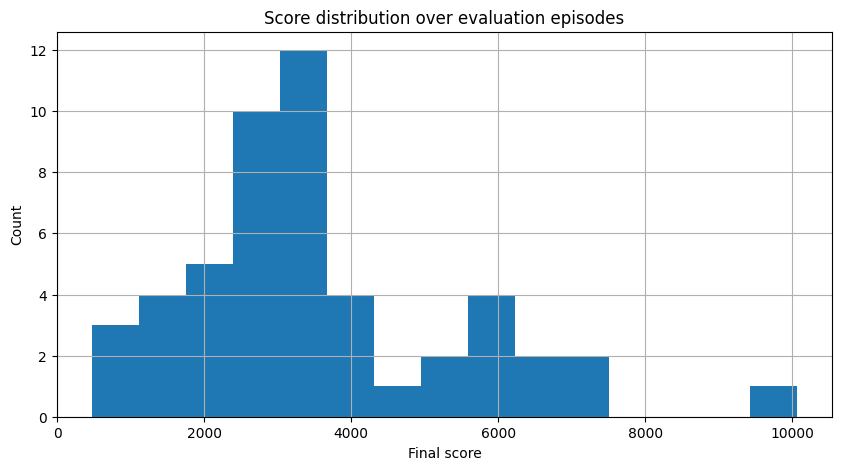

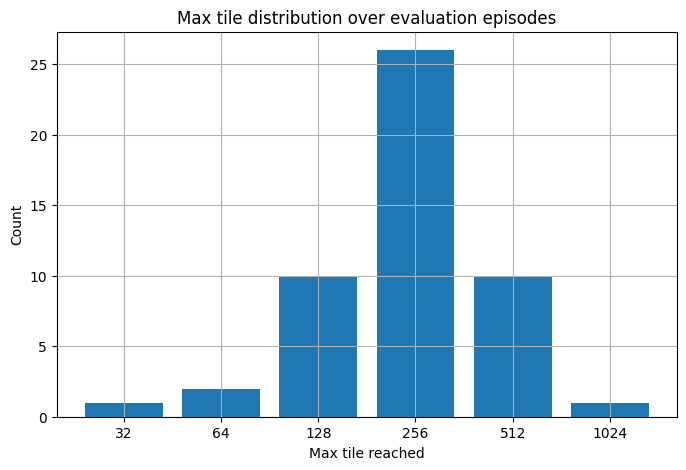

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [30]:
# ============================================
# 📊 Evaluate model and plot performance stats
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def unwrap_env(env):
    """Unwrap nested Gym wrappers to get the raw env with .board, .score, etc."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def eval_and_plot(model_path, episodes=50, deterministic=True):
    """
    Evaluate a trained MaskablePPO model:
      - runs `episodes` games
      - prints summary stats
      - plots:
          1) histogram of scores
          2) bar chart of max tile counts
    """
    # Load model
    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        env = Game2048MaskedEnvSimple()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    scores = np.array(scores)
    max_tiles_arr = np.array(max_tiles)
    lengths = np.array(lengths)

    # ----- Print summary -----
    tile_counts = Counter(max_tiles)
    print(f"Episodes:            {episodes}")
    print(f"Mean score:          {scores.mean():.1f}")
    print(f"Best score:          {scores.max():.1f}")
    print(f"Std score:           {scores.std():.1f}")
    print(f"Mean max tile:       {max_tiles_arr.mean():.1f}")
    print(f"Mean episode length: {lengths.mean():.1f}")
    print("Max tile distribution:")
    for tile in sorted(tile_counts.keys()):
        print(f"  {tile}: {tile_counts[tile]}")

    # ----- Plot score histogram -----
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=15)
    plt.xlabel("Final score")
    plt.ylabel("Count")
    plt.title("Score distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    # ----- Plot max tile distribution -----
    tiles_sorted = sorted(tile_counts.keys())
    counts_sorted = [tile_counts[t] for t in tiles_sorted]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(tiles_sorted)), counts_sorted)
    plt.xticks(range(len(tiles_sorted)), tiles_sorted)
    plt.xlabel("Max tile reached")
    plt.ylabel("Count")
    plt.title("Max tile distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    return {
        "scores": scores,
        "max_tiles": max_tiles_arr,
        "lengths": lengths,
        "tile_counts": tile_counts,
    }

# 🟢 RUN THIS: change the model path to your file
results = eval_and_plot("maskable_ppo_2048_new_cnn_masked_nparams_simple", episodes=50)


Episodes:            50
Mean score:          2624.9
Best score:          6252.0
Std score:           1110.1
Mean max tile:       215.0
Mean episode length: 229.9
Max tile distribution:
  128: 22
  256: 25
  512: 3


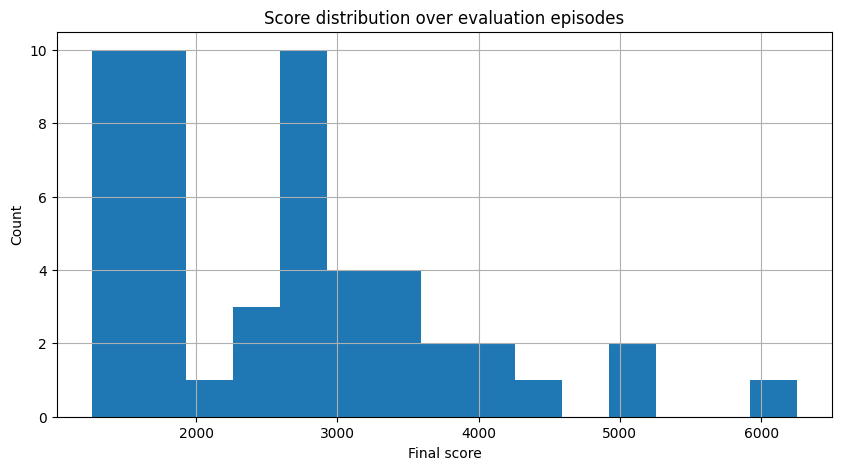

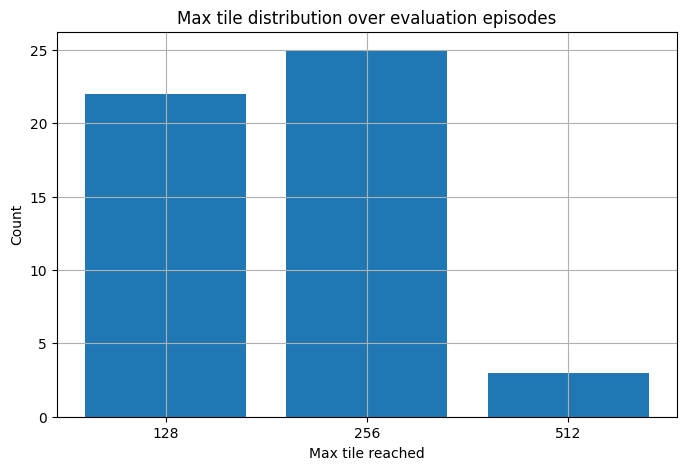

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [31]:
# ============================================
# 📊 Evaluate model and plot performance stats
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def unwrap_env(env):
    """Unwrap nested Gym wrappers to get the raw env with .board, .score, etc."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def eval_and_plot(model_path, episodes=50, deterministic=True):
    """
    Evaluate a trained MaskablePPO model:
      - runs `episodes` games
      - prints summary stats
      - plots:
          1) histogram of scores
          2) bar chart of max tile counts
    """
    # Load model
    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        env = Game2048MaskedEnv()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    scores = np.array(scores)
    max_tiles_arr = np.array(max_tiles)
    lengths = np.array(lengths)

    # ----- Print summary -----
    tile_counts = Counter(max_tiles)
    print(f"Episodes:            {episodes}")
    print(f"Mean score:          {scores.mean():.1f}")
    print(f"Best score:          {scores.max():.1f}")
    print(f"Std score:           {scores.std():.1f}")
    print(f"Mean max tile:       {max_tiles_arr.mean():.1f}")
    print(f"Mean episode length: {lengths.mean():.1f}")
    print("Max tile distribution:")
    for tile in sorted(tile_counts.keys()):
        print(f"  {tile}: {tile_counts[tile]}")

    # ----- Plot score histogram -----
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=15)
    plt.xlabel("Final score")
    plt.ylabel("Count")
    plt.title("Score distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    # ----- Plot max tile distribution -----
    tiles_sorted = sorted(tile_counts.keys())
    counts_sorted = [tile_counts[t] for t in tiles_sorted]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(tiles_sorted)), counts_sorted)
    plt.xticks(range(len(tiles_sorted)), tiles_sorted)
    plt.xlabel("Max tile reached")
    plt.ylabel("Count")
    plt.title("Max tile distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    return {
        "scores": scores,
        "max_tiles": max_tiles_arr,
        "lengths": lengths,
        "tile_counts": tile_counts,
    }

# 🟢 RUN THIS: change the model path to your file
results = eval_and_plot("maskable_ppo_2048_new_cnn_masked_nparams", episodes=50)


Episodes:            50
Mean score:          2942.7
Best score:          7424.0
Std score:           1824.7
Mean max tile:       243.8
Mean episode length: 243.0
Max tile distribution:
  32: 1
  64: 6
  128: 14
  256: 19
  512: 10


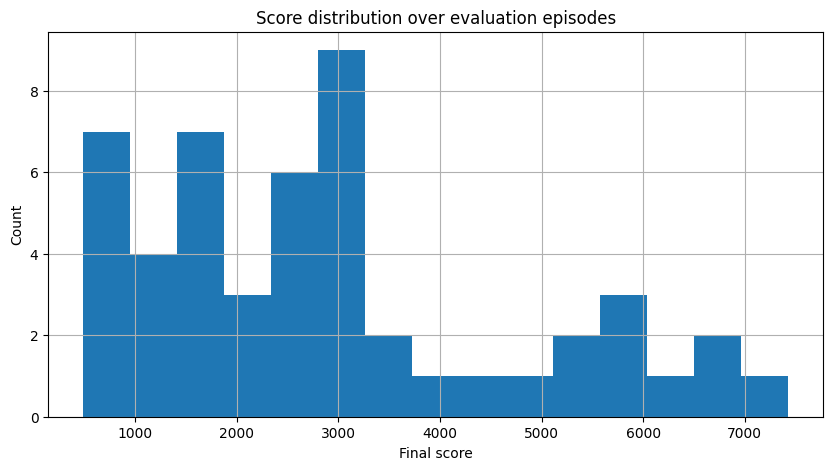

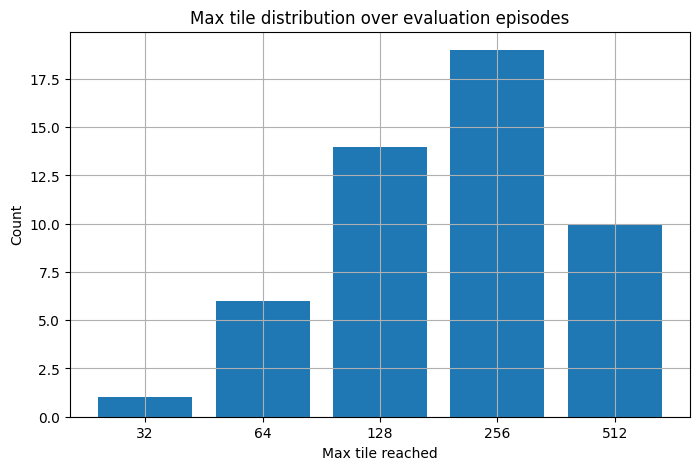

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [50]:
# ============================================
# 📊 Evaluate model and plot performance stats
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def unwrap_env(env):
    """Unwrap nested Gym wrappers to get the raw env with .board, .score, etc."""
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def eval_and_plot(model_path, episodes=50, deterministic=True):
    """
    Evaluate a trained MaskablePPO model:
      - runs `episodes` games
      - prints summary stats
      - plots:
          1) histogram of scores
          2) bar chart of max tile counts
    """
    # Load model
    model = MaskablePPO.load(model_path)

    scores = []
    max_tiles = []
    lengths = []

    for ep in range(episodes):
        env = Game2048MaskedEnvSimpleBiggerReward()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False
        steps = 0

        while not done:
            mask = raw_env.get_action_mask()
            action, _ = model.predict(
                obs,
                action_masks=mask,
                deterministic=deterministic
            )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated
            steps += 1

        scores.append(info["score"])
        max_tiles.append(info["max_tile"])
        lengths.append(steps)

    scores = np.array(scores)
    max_tiles_arr = np.array(max_tiles)
    lengths = np.array(lengths)

    # ----- Print summary -----
    tile_counts = Counter(max_tiles)
    print(f"Episodes:            {episodes}")
    print(f"Mean score:          {scores.mean():.1f}")
    print(f"Best score:          {scores.max():.1f}")
    print(f"Std score:           {scores.std():.1f}")
    print(f"Mean max tile:       {max_tiles_arr.mean():.1f}")
    print(f"Mean episode length: {lengths.mean():.1f}")
    print("Max tile distribution:")
    for tile in sorted(tile_counts.keys()):
        print(f"  {tile}: {tile_counts[tile]}")

    # ----- Plot score histogram -----
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=15)
    plt.xlabel("Final score")
    plt.ylabel("Count")
    plt.title("Score distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    # ----- Plot max tile distribution -----
    tiles_sorted = sorted(tile_counts.keys())
    counts_sorted = [tile_counts[t] for t in tiles_sorted]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(tiles_sorted)), counts_sorted)
    plt.xticks(range(len(tiles_sorted)), tiles_sorted)
    plt.xlabel("Max tile reached")
    plt.ylabel("Count")
    plt.title("Max tile distribution over evaluation episodes")
    plt.grid(True)
    plt.show()

    return {
        "scores": scores,
        "max_tiles": max_tiles_arr,
        "lengths": lengths,
        "tile_counts": tile_counts,
    }

# 🟢 RUN THIS: change the model path to your file
results = eval_and_plot("maskable_ppo_2048_new_cnn_masked_nparams_simple_big", episodes=50)


Loading PPO model...
Running PPO for 500 episodes...
Running Random Masked Agent for 500 episodes...

===== PPO Stats =====
Mean score: 3748.4
Std:        1881.3
Min/Max:    300 / 13592

===== RANDOM Stats =====
Mean score: 1083.1
Std:        550.6
Min/Max:    216 / 2968


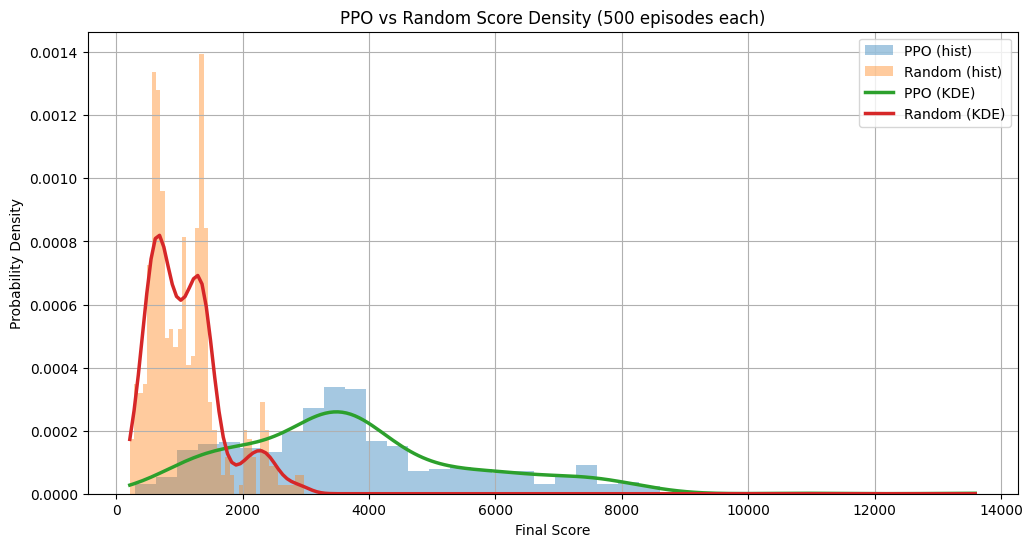

In [46]:
# ================================================================
# 📊 PPO vs Random: Score Probability Density (Histogram + KDE)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt

def unwrap_env(env):
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def run_agent(model=None, episodes=500, deterministic=True):
    """
    Runs either:
      - PPO model (if model is not None)
      - masked random agent (if model is None)
    Returns: numpy array of scores
    """
    scores = []

    for ep in range(episodes):
        env = Game2048MaskedEnvSimpleBiggerReward()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False

        while not done:
            mask = raw_env.get_action_mask()

            if model is None:
                # === random masked agent ===
                valid_actions = np.where(mask)[0]
                action = int(np.random.choice(valid_actions))
            else:
                # === PPO agent ===
                action, _ = model.predict(
                    obs,
                    action_masks=mask,
                    deterministic=deterministic
                )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated

        scores.append(info["score"])

    return np.array(scores, dtype=np.float32)


def kde_curve(data, xs):
    """Gaussian KDE with Silverman bandwidth (manual, no extra libs)."""
    std = data.std()
    if std == 0:
        return np.zeros_like(xs)

    n = len(data)
    h = 1.06 * std * n ** (-1/5)   # bandwidth
    h = max(h, 1e-6)

    densities = []
    for x in xs:
        u = (x - data) / h
        k = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        densities.append(k.mean() / h)
    return np.array(densities)


def compare_ppo_vs_random(model_path, episodes=500):
    from sb3_contrib import MaskablePPO

    print("Loading PPO model...")
    model = MaskablePPO.load(model_path)

    print(f"Running PPO for {episodes} episodes...")
    ppo_scores = run_agent(model, episodes)

    print(f"Running Random Masked Agent for {episodes} episodes...")
    rand_scores = run_agent(None, episodes)

    # Print stats
    print("\n===== PPO Stats =====")
    print(f"Mean score: {ppo_scores.mean():.1f}")
    print(f"Std:        {ppo_scores.std():.1f}")
    print(f"Min/Max:    {ppo_scores.min():.0f} / {ppo_scores.max():.0f}")

    print("\n===== RANDOM Stats =====")
    print(f"Mean score: {rand_scores.mean():.1f}")
    print(f"Std:        {rand_scores.std():.1f}")
    print(f"Min/Max:    {rand_scores.min():.0f} / {rand_scores.max():.0f}")

    # ----- Plot PDF -----
    plt.figure(figsize=(12, 6))

    # Range for KDE
    xmin = min(ppo_scores.min(), rand_scores.min())
    xmax = max(ppo_scores.max(), rand_scores.max())
    xs = np.linspace(xmin, xmax, 200)

    # KDE curves
    ppo_kde = kde_curve(ppo_scores, xs)
    rand_kde = kde_curve(rand_scores, xs)

    # Histograms (density)
    plt.hist(ppo_scores, bins=40, density=True, alpha=0.4, label="PPO (hist)")
    plt.hist(rand_scores, bins=40, density=True, alpha=0.4, label="Random (hist)")

    # KDE smoothed curves
    plt.plot(xs, ppo_kde, linewidth=2.5, label="PPO (KDE)")
    plt.plot(xs, rand_kde, linewidth=2.5, label="Random (KDE)")

    plt.title(f"PPO vs Random Score Density ({episodes} episodes each)")
    plt.xlabel("Final Score")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.show()

    return ppo_scores, rand_scores


# 🟢 RUN THIS
ppo_scores, rand_scores = compare_ppo_vs_random(
    "maskable_ppo_2048_new_cnn_masked_nparams_simple_big",
    episodes=500   # bump to 1000 if you want
)


Loading PPO model...
Running PPO for 500 episodes...
Running Random Masked Agent for 500 episodes...

===== PPO Stats =====
Mean score: 3304.1
Std:        1799.6
Min/Max:    336 / 12160

===== RANDOM Stats =====
Mean score: 1093.2
Std:        530.6
Min/Max:    180 / 3080


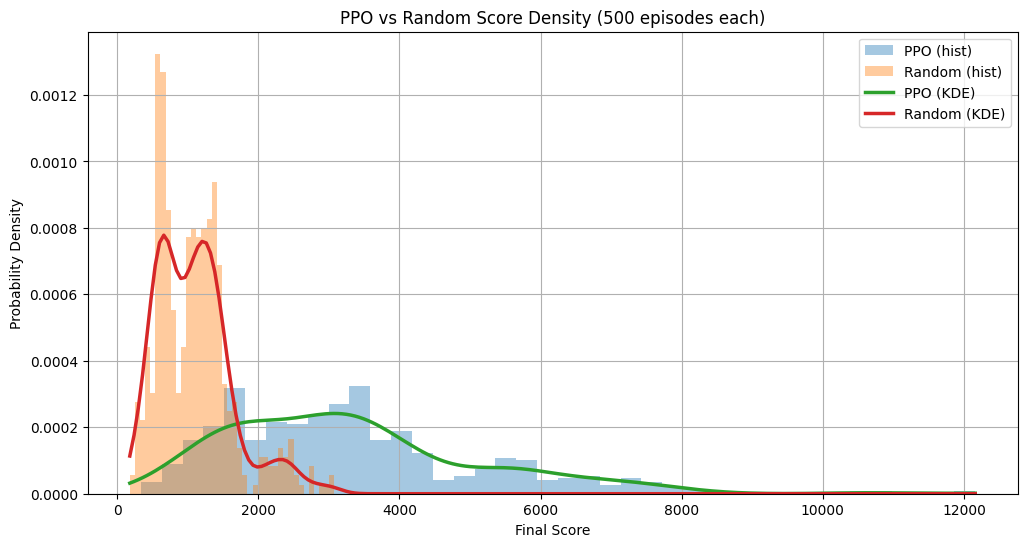

In [48]:
# ================================================================
# 📊 PPO vs Random: Score Probability Density (Histogram + KDE)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt

def unwrap_env(env):
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def run_agent(model=None, episodes=500, deterministic=True):
    """
    Runs either:
      - PPO model (if model is not None)
      - masked random agent (if model is None)
    Returns: numpy array of scores
    """
    scores = []

    for ep in range(episodes):
        env = Game2048MaskedEnvSimple()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False

        while not done:
            mask = raw_env.get_action_mask()

            if model is None:
                # === random masked agent ===
                valid_actions = np.where(mask)[0]
                action = int(np.random.choice(valid_actions))
            else:
                # === PPO agent ===
                action, _ = model.predict(
                    obs,
                    action_masks=mask,
                    deterministic=deterministic
                )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated

        scores.append(info["score"])

    return np.array(scores, dtype=np.float32)


def kde_curve(data, xs):
    """Gaussian KDE with Silverman bandwidth (manual, no extra libs)."""
    std = data.std()
    if std == 0:
        return np.zeros_like(xs)

    n = len(data)
    h = 1.06 * std * n ** (-1/5)   # bandwidth
    h = max(h, 1e-6)

    densities = []
    for x in xs:
        u = (x - data) / h
        k = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        densities.append(k.mean() / h)
    return np.array(densities)


def compare_ppo_vs_random(model_path, episodes=500):
    from sb3_contrib import MaskablePPO

    print("Loading PPO model...")
    model = MaskablePPO.load(model_path)

    print(f"Running PPO for {episodes} episodes...")
    ppo_scores = run_agent(model, episodes)

    print(f"Running Random Masked Agent for {episodes} episodes...")
    rand_scores = run_agent(None, episodes)

    # Print stats
    print("\n===== PPO Stats =====")
    print(f"Mean score: {ppo_scores.mean():.1f}")
    print(f"Std:        {ppo_scores.std():.1f}")
    print(f"Min/Max:    {ppo_scores.min():.0f} / {ppo_scores.max():.0f}")

    print("\n===== RANDOM Stats =====")
    print(f"Mean score: {rand_scores.mean():.1f}")
    print(f"Std:        {rand_scores.std():.1f}")
    print(f"Min/Max:    {rand_scores.min():.0f} / {rand_scores.max():.0f}")

    # ----- Plot PDF -----
    plt.figure(figsize=(12, 6))

    # Range for KDE
    xmin = min(ppo_scores.min(), rand_scores.min())
    xmax = max(ppo_scores.max(), rand_scores.max())
    xs = np.linspace(xmin, xmax, 200)

    # KDE curves
    ppo_kde = kde_curve(ppo_scores, xs)
    rand_kde = kde_curve(rand_scores, xs)

    # Histograms (density)
    plt.hist(ppo_scores, bins=40, density=True, alpha=0.4, label="PPO (hist)")
    plt.hist(rand_scores, bins=40, density=True, alpha=0.4, label="Random (hist)")

    # KDE smoothed curves
    plt.plot(xs, ppo_kde, linewidth=2.5, label="PPO (KDE)")
    plt.plot(xs, rand_kde, linewidth=2.5, label="Random (KDE)")

    plt.title(f"PPO vs Random Score Density ({episodes} episodes each)")
    plt.xlabel("Final Score")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.show()

    return ppo_scores, rand_scores


# 🟢 RUN THIS
ppo_scores, rand_scores = compare_ppo_vs_random(
    "maskable_ppo_2048_new_cnn_masked_nparams_simple",
    episodes=500   # bump to 1000 if you want
)


Loading PPO model...
Running PPO for 500 episodes...
Running Random Masked Agent for 500 episodes...

===== PPO Stats =====
Mean score: 2595.8
Std:        1286.3
Min/Max:    464 / 10312

===== RANDOM Stats =====
Mean score: 1111.4
Std:        549.3
Min/Max:    192 / 3156


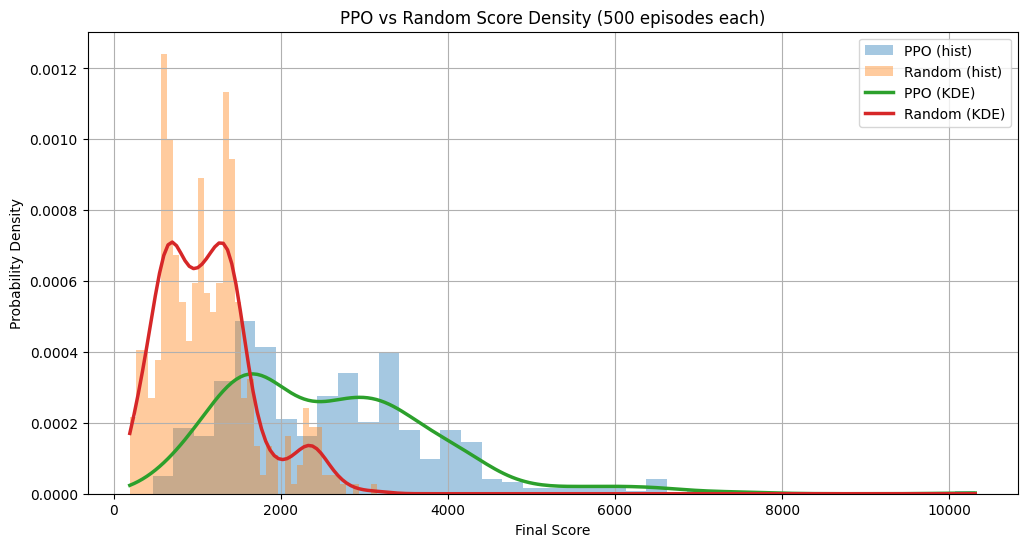

In [49]:
# ================================================================
# 📊 PPO vs Random: Score Probability Density (Histogram + KDE)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt

def unwrap_env(env):
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def run_agent(model=None, episodes=500, deterministic=True):
    """
    Runs either:
      - PPO model (if model is not None)
      - masked random agent (if model is None)
    Returns: numpy array of scores
    """
    scores = []

    for ep in range(episodes):
        env = Game2048MaskedEnv()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False

        while not done:
            mask = raw_env.get_action_mask()

            if model is None:
                # === random masked agent ===
                valid_actions = np.where(mask)[0]
                action = int(np.random.choice(valid_actions))
            else:
                # === PPO agent ===
                action, _ = model.predict(
                    obs,
                    action_masks=mask,
                    deterministic=deterministic
                )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated

        scores.append(info["score"])

    return np.array(scores, dtype=np.float32)


def kde_curve(data, xs):
    """Gaussian KDE with Silverman bandwidth (manual, no extra libs)."""
    std = data.std()
    if std == 0:
        return np.zeros_like(xs)

    n = len(data)
    h = 1.06 * std * n ** (-1/5)   # bandwidth
    h = max(h, 1e-6)

    densities = []
    for x in xs:
        u = (x - data) / h
        k = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        densities.append(k.mean() / h)
    return np.array(densities)


def compare_ppo_vs_random(model_path, episodes=500):
    from sb3_contrib import MaskablePPO

    print("Loading PPO model...")
    model = MaskablePPO.load(model_path)

    print(f"Running PPO for {episodes} episodes...")
    ppo_scores = run_agent(model, episodes)

    print(f"Running Random Masked Agent for {episodes} episodes...")
    rand_scores = run_agent(None, episodes)

    # Print stats
    print("\n===== PPO Stats =====")
    print(f"Mean score: {ppo_scores.mean():.1f}")
    print(f"Std:        {ppo_scores.std():.1f}")
    print(f"Min/Max:    {ppo_scores.min():.0f} / {ppo_scores.max():.0f}")

    print("\n===== RANDOM Stats =====")
    print(f"Mean score: {rand_scores.mean():.1f}")
    print(f"Std:        {rand_scores.std():.1f}")
    print(f"Min/Max:    {rand_scores.min():.0f} / {rand_scores.max():.0f}")

    # ----- Plot PDF -----
    plt.figure(figsize=(12, 6))

    # Range for KDE
    xmin = min(ppo_scores.min(), rand_scores.min())
    xmax = max(ppo_scores.max(), rand_scores.max())
    xs = np.linspace(xmin, xmax, 200)

    # KDE curves
    ppo_kde = kde_curve(ppo_scores, xs)
    rand_kde = kde_curve(rand_scores, xs)

    # Histograms (density)
    plt.hist(ppo_scores, bins=40, density=True, alpha=0.4, label="PPO (hist)")
    plt.hist(rand_scores, bins=40, density=True, alpha=0.4, label="Random (hist)")

    # KDE smoothed curves
    plt.plot(xs, ppo_kde, linewidth=2.5, label="PPO (KDE)")
    plt.plot(xs, rand_kde, linewidth=2.5, label="Random (KDE)")

    plt.title(f"PPO vs Random Score Density ({episodes} episodes each)")
    plt.xlabel("Final Score")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.show()

    return ppo_scores, rand_scores


# 🟢 RUN THIS
ppo_scores, rand_scores = compare_ppo_vs_random(
    "maskable_ppo_2048_new_cnn_masked_nparams",
    episodes=500   # bump to 1000 if you want
)


In [ ]:
# ================================================================
# 📊 PPO vs Random: Score Probability Density (Histogram + KDE)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt

def unwrap_env(env):
    raw = env
    while hasattr(raw, "env"):
        raw = raw.env
    return raw

def run_agent(model=None, episodes=500, deterministic=True):
    """
    Runs either:
      - PPO model (if model is not None)
      - masked random agent (if model is None)
    Returns: numpy array of scores
    """
    scores = []

    for ep in range(episodes):
        env = Game2048MaskedEnvSimpleBiggerReward()
        env = ActionMasker(env, mask_fn)
        raw_env = unwrap_env(env)

        obs, info = env.reset()
        done = False

        while not done:
            mask = raw_env.get_action_mask()

            if model is None:
                # === random masked agent ===
                valid_actions = np.where(mask)[0]
                action = int(np.random.choice(valid_actions))
            else:
                # === PPO agent ===
                action, _ = model.predict(
                    obs,
                    action_masks=mask,
                    deterministic=deterministic
                )

            obs, reward, terminated, truncated, info = env.step(int(action))
            done = terminated or truncated

        scores.append(info["score"])

    return np.array(scores, dtype=np.float32)


def kde_curve(data, xs):
    """Gaussian KDE with Silverman bandwidth (manual, no extra libs)."""
    std = data.std()
    if std == 0:
        return np.zeros_like(xs)

    n = len(data)
    h = 1.06 * std * n ** (-1/5)   # bandwidth
    h = max(h, 1e-6)

    densities = []
    for x in xs:
        u = (x - data) / h
        k = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        densities.append(k.mean() / h)
    return np.array(densities)


def compare_ppo_vs_random(model_path, episodes=500):
    from sb3_contrib import MaskablePPO

    print("Loading PPO model...")
    model = MaskablePPO.load(model_path)

    print(f"Running PPO for {episodes} episodes...")
    ppo_scores = run_agent(model, episodes)

    print(f"Running Random Masked Agent for {episodes} episodes...")
    rand_scores = run_agent(None, episodes)

    # Print stats
    print("\n===== PPO Stats =====")
    print(f"Mean score: {ppo_scores.mean():.1f}")
    print(f"Std:        {ppo_scores.std():.1f}")
    print(f"Min/Max:    {ppo_scores.min():.0f} / {ppo_scores.max():.0f}")

    print("\n===== RANDOM Stats =====")
    print(f"Mean score: {rand_scores.mean():.1f}")
    print(f"Std:        {rand_scores.std():.1f}")
    print(f"Min/Max:    {rand_scores.min():.0f} / {rand_scores.max():.0f}")

    # ----- Plot PDF -----
    plt.figure(figsize=(12, 6))

    # Range for KDE
    xmin = min(ppo_scores.min(), rand_scores.min())
    xmax = max(ppo_scores.max(), rand_scores.max())
    xs = np.linspace(xmin, xmax, 200)

    # KDE curves
    ppo_kde = kde_curve(ppo_scores, xs)
    rand_kde = kde_curve(rand_scores, xs)

    # Histograms (density)
    plt.hist(ppo_scores, bins=40, density=True, alpha=0.4, label="PPO (hist)")
    plt.hist(rand_scores, bins=40, density=True, alpha=0.4, label="Random (hist)")

    # KDE smoothed curves
    plt.plot(xs, ppo_kde, linewidth=2.5, label="PPO (KDE)")
    plt.plot(xs, rand_kde, linewidth=2.5, label="Random (KDE)")

    plt.title(f"PPO vs Random Score Density ({episodes} episodes each)")
    plt.xlabel("Final Score")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.show()

    return ppo_scores, rand_scores


# 🟢 RUN THIS
ppo_scores, rand_scores = compare_ppo_vs_random(
    "maskable_ppo_2048_new_cnn_masked_nparams_simple_big_hps",
    episodes=500   # bump to 1000 if you want
)


Loading PPO model...
Running PPO for 500 episodes...
